<a href="https://colab.research.google.com/github/mathanamathav/Image-Captioning/blob/main/Notebooks/nlp_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenizati
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
from keras.preprocessing.text import Tokenizer
from collections import Counter
from IPython.display import display
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from keras.applications.vgg16 import VGG16
tqdm().pandas()
     

<ipython-input-5-77590c4267f2>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [6]:
import string
 
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)


def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = '/content/drive/MyDrive/NLP SEM/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print(len(descriptions))

clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print(len(vocabulary))

save_descriptions(descriptions, 'descriptions.txt')

8092
8763


In [7]:
dir_Flickr_jpg = "/content/drive/MyDrive/NLP SEM/Flicker8k_Dataset"

dir_Flickr_text = "/content/drive/MyDrive/NLP SEM/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8099


In [ ]:
def extract_features(dirc):

  model = Xception(include_top=False, pooling='avg')
  features = {}

  for pic in tqdm(os.listdir(dirc)):
            file = dirc + "/" + pic
            image = Image.open(file)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
           
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            image_id = pic.split('.')[0]
            features[image_id] = feature
          
  return features

directory = '/content/drive/MyDrive/NLP SEM/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))

In [9]:
def load_doc(filename):
	file = open(filename, "r+")
  
	text = file.read()
	file.close()
	return text
 
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'start ' + ' '.join(image_desc) + ' end'
			descriptions[image_id].append(desc)
	return descriptions

bleu1=0.72
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

In [10]:
filename = '/content/drive/MyDrive/NLP SEM/Flickr8k_text/Flickr_8k.trainImages.txt'

train_imgs = load_set(filename)

train_descriptions = load_clean_descriptions("descriptions.txt",train_imgs)
train_features = load_photo_features('features.pkl',train_imgs)

In [11]:
def dict_to_list(descriptions):
   all_desc = []
   for key in descriptions.keys():
       [all_desc.append(d) for d in descriptions[key]]
   return all_desc


def create_tokenizer(descriptions):
   desc_list = dict_to_list(descriptions)
   tokenizer = Tokenizer()
   tokenizer.fit_on_texts(desc_list)
   return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 
def max_length(descriptions):
   desc_list = dict_to_list(descriptions)
   return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
max_length #Max_length of description is 32

32

In [12]:
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      
           feature = features[key][0]
           inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
           yield [[inp_image, inp_seq], op_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
   x_1, x_2, y = list(), list(), list()
  
   for desc in desc_list:
      
       seq = tokenizer.texts_to_sequences([desc])[0]
     
       for i in range(1, len(seq)):
          
           in_seq, out_seq = seq[:i], seq[i]
          
           in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
         
           out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
           x_1.append(feature)
           x_2.append(in_seq)
           y.append(out_seq)
   return np.array(x_1), np.array(x_2), np.array(y)

[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [13]:
from keras.utils import plot_model

def define_model(vocab_size, max_length):

   inputs1 = Input(shape=(2048,))
   fe1 = Dropout(0.5)(inputs1)
   fe2 = Dense(256, activation='relu')(fe1)
  
   inputs2 = Input(shape=(max_length,))
   se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
   se2 = Dropout(0.5)(se1)
   se3 = LSTM(256)(se2)
  
   decoder1 = add([fe2, se3])
   decoder2 = Dense(256, activation='relu')(decoder1)
   outputs = Dense(vocab_size, activation='softmax')(decoder2)
  
   model = Model(inputs=[inputs1, inputs2], outputs=outputs)
   model.compile(loss='categorical_crossentropy', optimizer='adam')
 
   print(model.summary())
   plot_model(model, to_file='model.png', show_shapes=True)
   return model

In [14]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# creating a directory named models to save our models
os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
   model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
   model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']    

<ipython-input-14-8adef47d79ac>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 625s 104ms/step - loss: 2.7984


# test

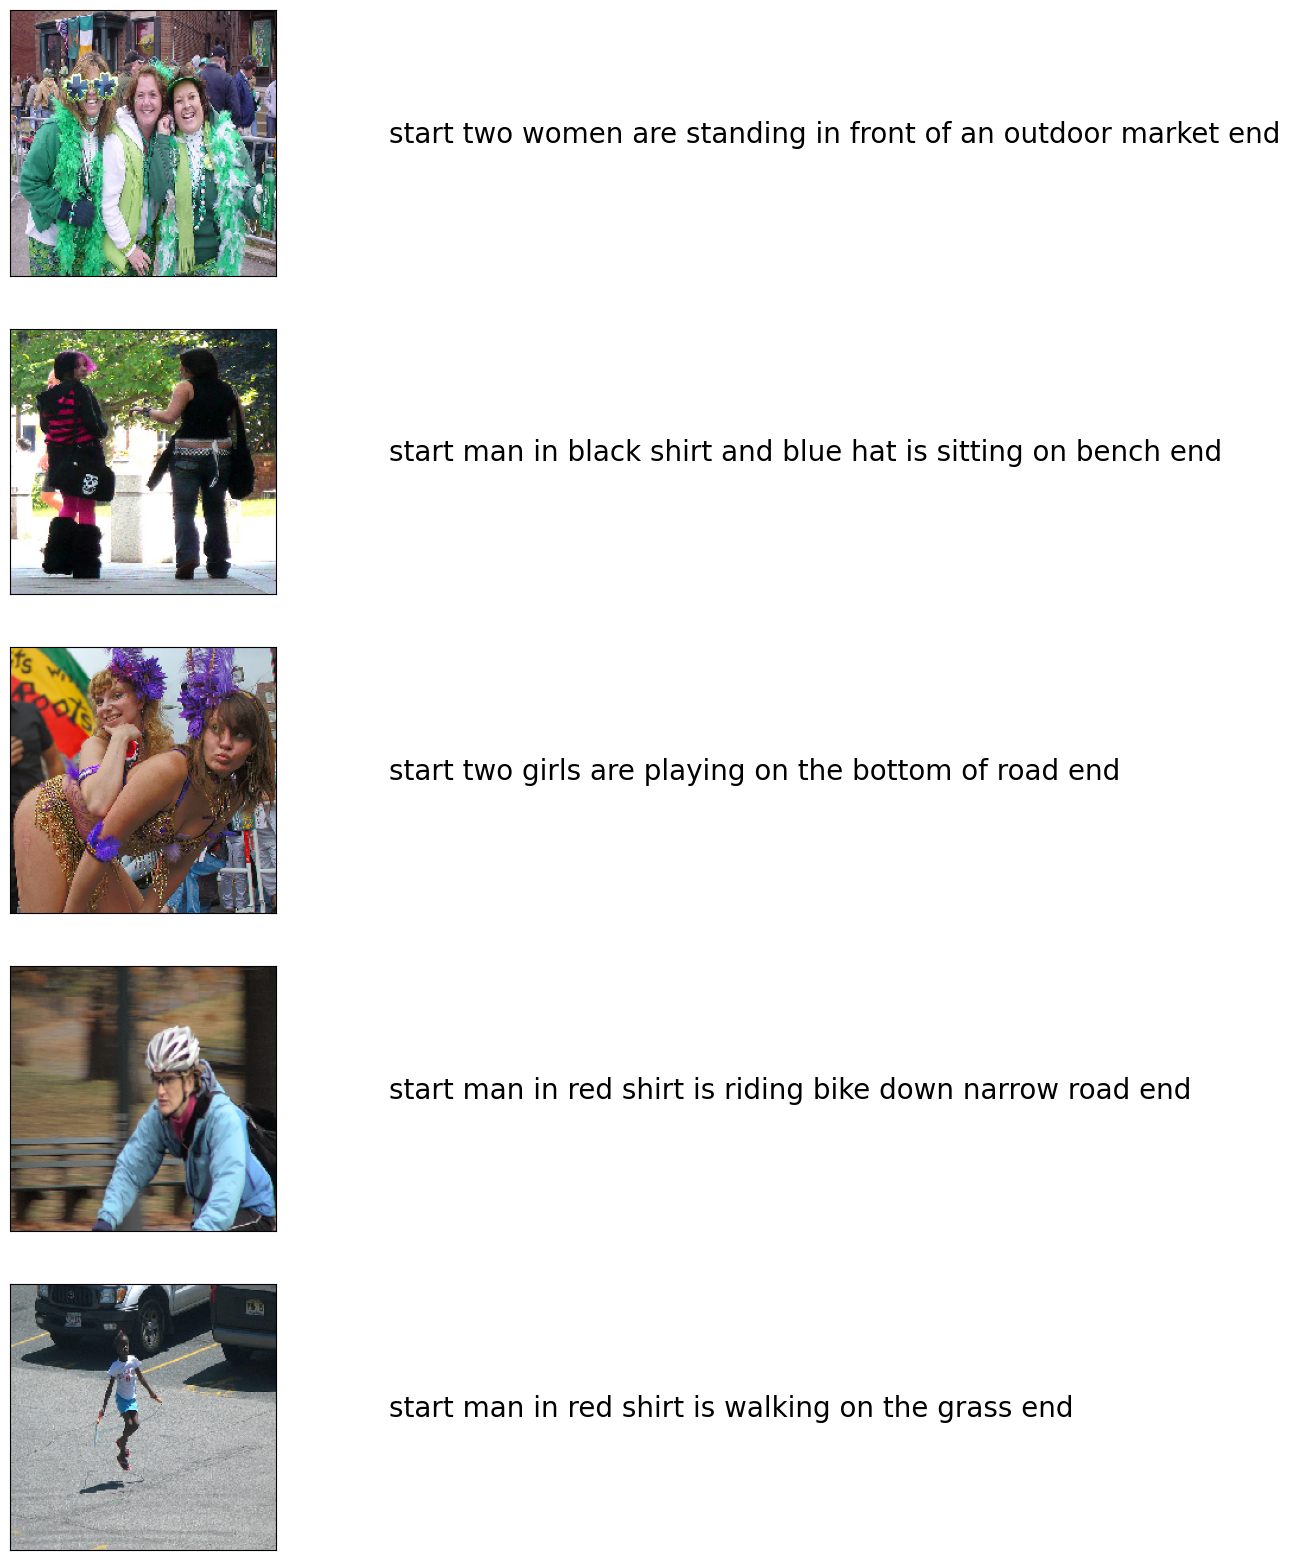

In [19]:
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/models/model_9.h5')
     

def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = [all_features[k] for k in dataset]
	return features
     

filename = '/content/drive/MyDrive/NLP SEM/Flickr8k_text/Flickr_8k.testImages.txt'

test_imgs = list(load_set(filename))

test_descriptions = load_clean_descriptions("descriptions.txt",test_imgs)
test_features = load_photo_features('/content/features.pkl',test_imgs)
     

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image,maxlen=32):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'start'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "end":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(test_imgs[8:13],test_features[8:13]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm+'.jpg'
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature)
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [20]:
sorted_dict = dict(sorted(test_descriptions.items(), key=lambda x: test_imgs.index(x[0])))
res=list(sorted_dict.values())

In [21]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])     
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I is dog"
references = [reference.split()]## references must be a list containing list. 
#print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

smoothie = SmoothingFunction().method1  # define smoothing function
score = sentence_bleu(references, hypothesis, smoothing_function=smoothie)
print("BLEU={:4.3f}".format(score))

BLEU=0.135


In [22]:
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(test_imgs,test_features,res):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(test_imgs))))
    
    #caption_true = [ index_word[j]  for i in tokenized_text ]     
    #caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    ground_truth = [[word for word in j.split()] for j in caption for caption in tokenized_text]
    print("Ground_truth")
    print(ground_truth)
    # Convert the generated caption to a list of word
    
    # Calculate the BLEU score for this image
    caption = predict_caption(image_feature)
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    print("Caption")
    print(caption)
    smoothie = SmoothingFunction().method1  # define smoothing function
    bleu = sentence_bleu(ground_truth, caption, smoothing_function=smoothie)
    print(bleu)
    #bleu = sentence_bleu(ground_truth,caption)
    bleus.append(bleu)
    if count==2:
      break
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,ground_truth,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,ground_truth,caption))
    bleui=(np.mean(bleus))
     

print("Mean BLEU Score for testing data")
print(bleu1)

Ground_truth
[['s'], ['s'], ['s'], ['s'], ['s'], ['t'], ['t'], ['t'], ['t'], ['t'], ['a'], ['a'], ['a'], ['a'], ['a'], ['r'], ['r'], ['r'], ['r'], ['r'], ['t'], ['t'], ['t'], ['t'], ['t'], [], [], [], [], [], ['m'], ['m'], ['m'], ['m'], ['m'], ['a'], ['a'], ['a'], ['a'], ['a'], ['n'], ['n'], ['n'], ['n'], ['n'], [], [], [], [], [], ['i'], ['i'], ['i'], ['i'], ['i'], ['n'], ['n'], ['n'], ['n'], ['n'], [], [], [], [], [], ['r'], ['r'], ['r'], ['r'], ['r'], ['e'], ['e'], ['e'], ['e'], ['e'], ['d'], ['d'], ['d'], ['d'], ['d'], [], [], [], [], [], ['s'], ['s'], ['s'], ['s'], ['s'], ['h'], ['h'], ['h'], ['h'], ['h'], ['i'], ['i'], ['i'], ['i'], ['i'], ['r'], ['r'], ['r'], ['r'], ['r'], ['t'], ['t'], ['t'], ['t'], ['t'], [], [], [], [], [], ['i'], ['i'], ['i'], ['i'], ['i'], ['s'], ['s'], ['s'], ['s'], ['s'], [], [], [], [], [], ['w'], ['w'], ['w'], ['w'], ['w'], ['a'], ['a'], ['a'], ['a'], ['a'], ['l'], ['l'], ['l'], ['l'], ['l'], ['k'], ['k'], ['k'], ['k'], ['k'], ['i'], ['i'], ['i'], ['i']

In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
    
    

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


def predict_caption(model,tokenizer,image,maxlen=32):
    '''
    image.shape = (1,4462)
    '''
    index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
    in_text = 'start'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "end":
            break
    return(in_text)

In [ ]:
from google.colab import files
     

uploaded = files.upload()

# Get the name of the uploaded file
filename = next(iter(uploaded))

In [ ]:
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(filename, xception_model)
img = Image.open(filename)
description = predict_caption(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)